In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import numpy as np

torch.manual_seed(1)

EPOCH = 2
LR = 0.001
DOWNLOAD_MNIST = True

train_data = torchvision.datasets.MNIST(root='./mnist/', train=True, transform=torchvision.transforms.ToTensor(),
                                        download=DOWNLOAD_MNIST, )
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
print(train_data.train_data.shape)

train_x = torch.unsqueeze(train_data.train_data, dim=1).type(torch.FloatTensor) / 255.
train_y = train_data.train_labels
print(train_x.shape)

test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000] / 255.  # Tensor on GPU
test_y = test_data.test_labels[:2000]

torch.Size([60000, 28, 28])
torch.Size([60000, 1, 28, 28])


D:\Software\miniconda3\envs\pt1.8\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
D:\Software\miniconda3\envs\pt1.8\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
D:\Software\miniconda3\envs\pt1.8\lib\site-packages\torchvision\datasets\mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
D:\Software\miniconda3\envs\pt1.8\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [10]:
def ConvModule(in_channels, out_channels, order='CBA'):
    # 'CBA': Conv + BN + Activation
    # 'CAB': Conv + Activation + BN
    assert order in ['CBA', 'CAB']
    module_pack = []
    module_pack.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, bias=False))
    if order == 'CBA':
        module_pack.append(nn.BatchNorm2d(out_channels))
        module_pack.append(nn.ReLU())
    else:
        module_pack.append(nn.ReLU())  
        module_pack.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*module_pack)


class Classifier(nn.Module):
    def __init__(self, in_channels, base_channels, num_classes):
        super(Classifier, self).__init__()
        self.conv_list = nn.ModuleList()
        for _ in range(5):
            self.conv_list.append(ConvModule(in_channels, base_channels))
            in_channels = base_channels
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.out_linear = nn.Linear(base_channels, num_classes)

    def forward(self, x):
        for conv in self.conv_list:
            x = conv(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        output = self.out_linear(x)
        
        return output


In [12]:
fc = Classifier(in_channels=1, base_channels=32, num_classes=10)

optimizer = torch.optim.Adam(fc.parameters(), lr=LR)
# loss_func = nn.MSELoss()
loss_func = nn.CrossEntropyLoss()

data_size = 20000
batch_size = 50

for epoch in range(EPOCH):
    random_indx = np.random.permutation(data_size)
    for batch_i in range(data_size // batch_size):
        indx = random_indx[batch_i * batch_size:(batch_i + 1) * batch_size]

        b_x = train_x[indx, :]
        b_y = train_y[indx]

        output = fc(b_x)
        loss = loss_func(output, b_y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch_i % 50 == 0:
            test_output = fc(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            # pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = torch.sum(pred_y == test_y).type(torch.FloatTensor) / test_y.size(0)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| test accuracy: %.3f' % accuracy)

test_output = fc(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.squeeze()  # move the computation in GPU

print(pred_y, 'prediction number')
print(test_y[:10], 'real number')

tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.0683e-01,
           2.4329e-01, 2.6721e-01],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.5371e-01,
           0.0000e+00, 3.3708e-01],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 1.3351e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.0339e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.2289e+00, 1.3197e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 2.4470e-02],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.8866e-02,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.8861e+00, 1.2012e+00, 1.6026e+00,  ..., 0.0000

KeyboardInterrupt: 

In [6]:
test_output = fc(test_x[:1])
pred_y = torch.max(test_output, 1)[1].data.squeeze()  # move the computation in GPU

print(pred_y, 'prediction number')
print(test_y[:1], 'real number')

tensor(7) prediction number
tensor([7]) real number


In [21]:
test_output

tensor([[-1.7228, -5.7907,  3.7918,  4.6222, -2.6630,  0.7286,  0.8211, 11.8054,
          0.9796,  3.1643]], grad_fn=<AddmmBackward>)

In [18]:
test_x[:1].shape

torch.Size([1, 1, 28, 28])

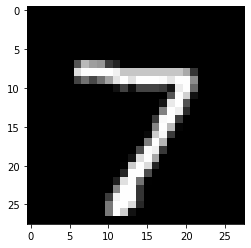

In [19]:
plt.imshow(test_x[:1].numpy().squeeze(), 'gray')

In [2]:
import torch
torch.eye(10)
0, 1, 2, ..., 9 

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])